In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'cse493g1/project/data/test-large-dataset/'

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cse493g1/project/data/test-large-dataset


In [2]:
!pip install transformers
from transformers import AutoTokenizer, LxmertForQuestionAnswering
import models.modelling_frcnn as modelling_frcnn
from models.processing_image import Preprocess
from models.utils import Config
import torch
import json
import torchvision
import glob
import numpy as np
import os
import importlib
import models.utils as utils
from google.colab.patches import cv2_imshow

# importlib.reload(modelling_frcnn)

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
tokenizer = AutoTokenizer.from_pretrained('unc-nlp/lxmert-vqa-uncased')
model = LxmertForQuestionAnswering.from_pretrained('unc-nlp/lxmert-vqa-uncased').cuda()

frcnn_cfg = Config.from_pretrained('unc-nlp/frcnn-vg-finetuned') # loads heads, hidden layer data, etc. 
frcnn = modelling_frcnn.GeneralizedRCNN.from_pretrained('unc-nlp/frcnn-vg-finetuned', config=frcnn_cfg).cuda()
image_preprocess = Preprocess(frcnn_cfg)

VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
vqa_answers = utils.get_data(VQA_URL)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [4]:
# Language features
# https://huggingface.co/docs/transformers/main_classes/tokenizer
# extract questions
input_questions = json.load(open('v3_OpenEnded_mscoco_val2014_questions_gen.json'))
list.sort(input_questions['questions'], key = lambda item: item['image_id']) # sort by image
print('questions:', len(input_questions['questions']))
question_data = {'visited': [], 'duplicate_index': [], 'ordered_questions': [], 'question_ids': []}
count = 0
for q in input_questions['questions']:
    id = q['image_id']
    if id not in question_data['visited']:
        question_data['visited'].append(id)
    else:
        print('duplicate image id:', id) # mark duplicate
        question_data['duplicate_index'].append(count) # mark second occurrence
    question_data['ordered_questions'].append(q['question'])
    question_data['question_ids'].append(q['question_id'])
    count += 1

# make sure annotations matching questions
annotations = json.load(open('v3_mscoco_val2014_annotations_gen.json'))
print('annotations:', len(annotations['annotations']))
for a in annotations['annotations']:
  if a['question_id'] not in question_data['question_ids']:
    print('ohh no')

# embed questions
tokens = tokenizer(
    question_data['ordered_questions'], 
    padding="max_length", 
    max_length=20, 
    truncation=True, 
    return_token_type_ids=True, # if multiple phrases together
    return_attention_mask=True, # for padding
    add_special_tokens=True,
    return_tensors='pt')
inputs = tokens['input_ids']
print('test question:', question_data['ordered_questions'][0])
print('duplicate indices:', question_data['duplicate_index'])
print('unique question images:', len(question_data['visited']))

questions: 563
duplicate image id: 279386
duplicate image id: 388026
duplicate image id: 400189
duplicate image id: 434263
annotations: 563
test question: Are the girls on for twins?
duplicate indices: [283, 372, 389, 428]
unique question images: 559


In [5]:
# process images into tensors
path = 'v3_val2014_gen'
file_list = []
count = 0
for filename in sorted(os.listdir(path)):
      filepath = path + '/' + filename
      file_list.append(filepath)
      if count + 1 in question_data['duplicate_index']:
          count += 1
          file_list.append(filepath)
      count += 1

      if int(filename[13:25].lstrip('0')) not in question_data['visited']: # check for extra images
        print(filename)

print('image number after accounting for duplicates:', len(file_list))

def load_img(file_list):
    """
    Loads images in the specified list into tensors
    """
    img_t = []
    for filename in file_list:
        img_t.append(torchvision.io.read_image(filename).movedim(0,2))
    return img_t

image number after accounting for duplicates: 563


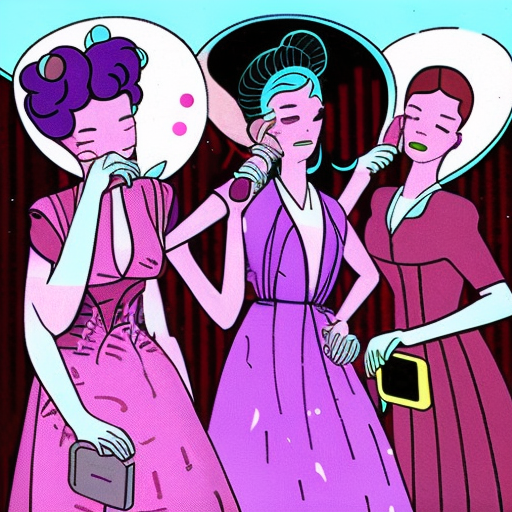

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Batch 0 finished
Batch 1 finished
Batch 2 finished
Batch 3 finished
Batch 4 finished
Batch 5 finished
Batch 6 finished
Batch 7 finished
Batch 8 finished
Batch 9 finished
Batch 10 finished
Batch 11 finished
Batch 12 finished
Batch 13 finished
Batch 14 finished
Batch 15 finished
Batch 16 finished
Batch 17 finished
Batch 18 finished
Batch 19 finished
Batch 20 finished
Batch 21 finished
Batch 22 finished
Batch 23 finished
Batch 24 finished
Batch 25 finished
Batch 26 finished
Batch 27 finished
Batch 28 finished
Batch 29 finished
Batch 30 finished
Batch 31 finished
Batch 32 finished
Batch 33 finished
Batch 34 finished
Batch 35 finished
Batch 36 finished
Batch 37 finished
Batch 38 finished
Batch 39 finished
Batch 40 finished
Batch 41 finished
Batch 42 finished
Batch 43 finished
Batch 44 finished
Batch 45 finished
Batch 46 finished
Batch 47 finished
Batch 48 finished
Batch 49 finished
Batch 50 finished
Batch 51 finished
Batch 52 finished
Batch 53 finished
Batch 54 finished
Batch 55 finished
Ba

In [6]:
# sample 
total = len(file_list)
random = np.random.randint(0, total)

# embed in batches
batch_size = 1
results = []
image_num = len(file_list)
for i in range(int(np.ceil(image_num / batch_size))):
    start = i * batch_size
    end = (i + 1) * batch_size if (i + 1) * batch_size <= image_num else image_num
    data = load_img(file_list[start:end])
    if i == 0:
      cv2_imshow(data[0].numpy())
    images, sizes, scales_yx = image_preprocess(data)
    images = images.to(device)
    sizes = sizes.to(device)
    scales_yx = scales_yx.to(device)
    # sizes is tensor of image sizes
    # scales_yx is how much each image scaled by to the max image size
    # images are adjusted images
    output_dict = frcnn(
        images, 
        sizes,
        scales_yx=scales_yx, 
        padding='max_detections',
        max_detections=frcnn_cfg.max_detections,
        return_tensors="pt"
    )
    results.append(output_dict)
    print(f'Batch {i} finished')

In [13]:
input_num = inputs.shape[0]
attention_mask = tokens.attention_mask
token_ids = tokens.token_type_ids
print(inputs.shape)
print(attention_mask.shape)
print(token_ids.shape)


torch.Size([563, 20])
torch.Size([563, 20])
torch.Size([563, 20])


In [21]:
predictions = []
for i in range(input_num):
  output_dict = results[i]
  normalized_boxes = output_dict.get('normalized_boxes')
  features = output_dict.get('roi_features')
  output_vqa = model(
      input_ids=inputs[i].unsqueeze(0).to(device),
      attention_mask=attention_mask[i].unsqueeze(0).to(device),
      visual_feats=features.to(device),
      visual_pos=normalized_boxes.to(device),
      token_type_ids=token_ids[i].unsqueeze(0).to(device),
      output_attentions=False 
  )
  pred = output_vqa['question_answering_score'].argmax(-1)
  predictions.append(vqa_answers[pred])
print(predictions)

['no', 'white', 'no', 'no', 'no', '8', 'sitting', 'scissors', '2', '4', '2', 'fence', 'no', '2', 'solid', 'apple', '2', 'spoon', 'rainy', 'tv', 'yes', 'purple', 'carpet', '2', 'no', '5', 'no', 'no', 'flowers', '4', 'yes', 'peas', 'yellow', 'yes', '2', 'yes', 'yes', 'no', '1', 'looking', 'yes', '0', 'concrete', '2', 'no', 'black', 'gothic', 'green', 'black', "can't see", 'toilet paper', '2', '2', 'surfboards', 'yes', 'yes', 'no', '0', 'black', 'brown', 'ascending', 'no', 'texas', 'no', '0', 'boats', 'yes', 'yes', 'fall', '2', 'yes', 'yes', 'nothing', 'white', '2', 'yes', '10', 'no', 'nothing', 'no', 'nobody', 'yes', '0', '0', 'black', 'blue', 'field', 'no', 'prom', 'no', 'no', 'no', 'no', '0', 'nothing', '1', '2', 'white', 'vase', 'no', '0', '400', 'street', '0', 'no', 'no', '0', 'black', 'yes', '1', 'no', 'no', '2', 'no', '3', '2 years', 'yes', '5', 'no', 'prom', '1', 'desk', 'glass', 'yes', 'yes', '2', '0', '2', '10 years', '3', 'white', 'no', 'no', 'prom', '2', 'nothing', 'moving', '

In [28]:
print(input_questions['questions'][:10])
answers = []
for i in range(input_num):
  answers.append({'image_id': input_questions['questions'][i]['image_id'],
                  'question_id': input_questions['questions'][i]['question_id'],
                  'answer': predictions[i]})
json.dump(answers, open('v3_val2014_lxmert_predictions.json', 'w'))

{'image_id': 581482, 'question': 'What time is it right now?', 'question_id': 581482000}
563
